# Exploratory Data Analysis of Weather in Illinois

In [60]:
# DataFrame library
import pandas as pd

# Array library
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

In [61]:
# Loads the data based on the desired data types and columns
raw_weather_data = pd.read_parquet("./data/raw_weather.parquet", engine = "pyarrow")
raw_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19102488 entries, 0 to 19102487
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         string 
 1   date       string 
 2   time       string 
 3   element    string 
 4   value      float64
 5   qflag      string 
 6   latitude   float64
 7   longitude  float64
 8   name       string 
 9   elevation  float64
dtypes: float64(4), string(6)
memory usage: 1.4 GB


In [62]:
# The qflag represents quality of the measurement (we want the rows that don't have quality issues which is denoted <NA>)
raw_weather_data["qflag"].unique()

<StringArray>
[<NA>, 'I', 'L', 'D', 'S', 'O', 'W', 'K', 'X', 'G', 'M', 'Z', 'N', 'T', 'R']
Length: 15, dtype: string

In [63]:
# Unique elements to gather data from
# See the following website for more details https://docs.opendata.aws/noaa-ghcn-pds/readme.html#:~:text=SNWD%20%3D%20Snow%20depth%20(mm),temperature%20(tenths%20of%20degrees%20C)
raw_weather_data["element"].unique()

<StringArray>
['PRCP', 'SN32', 'SN52', 'SNOW', 'SNWD', 'SX32', 'SX52', 'TMAX', 'TMIN',
 'TOBS', 'WT01', 'WT03', 'WT04', 'WT06', 'WESD', 'WESF', 'WT11', 'WDF5',
 'WSFG', 'DAPR', 'TAVG', 'MDPR', 'AWND', 'WSF2', 'WSF5', 'WT05', 'WDF2',
 'WT02', 'WT08', 'EVAP', 'WDMV', 'WT18', 'PGTM', 'WDFG', 'MNPN', 'WT14',
 'MXPN', 'MDSF', 'MDEV', 'WT16', 'WT15', 'DAEV', 'WT07', 'WT09', 'MDWM',
 'WT17', 'DASF', 'DAWM', 'SX53', 'SN53', 'FMTM', 'TSUN', 'WT10', 'WT13',
 'RHAV', 'ADPT', 'ASLP', 'ASTP', 'RHMX', 'AWBT', 'RHMN', 'ACSH', 'WSF1',
 'WDF1', 'WT19', 'WV03', 'ACMH', 'WT21', 'WT22', 'WV20', 'SN12', 'SX12',
 'PSUN', 'SX03', 'SN02', 'SX02', 'SN03', 'WV18', 'WV01']
Length: 79, dtype: string

In [64]:
# Counts the total number of occurrences of an element for each element
element_count = raw_weather_data.groupby("element")["element"].count().sort_values()
element_count

element
WV01          1
WV18          1
PSUN          2
WT10         13
WV20         19
         ...   
TMIN    1678986
TMAX    1679778
SNWD    2695417
SNOW    3969024
PRCP    5189380
Name: element, Length: 79, dtype: int64

In [65]:
# Number of stations in Illinois
num_of_stations = raw_weather_data["name"].nunique()
num_of_stations

2005

In [66]:
raw_weather_data.shape

(19102488, 10)

In [67]:
# Replaces all nan values with "0000"
raw_weather_data["time"] = raw_weather_data["time"].fillna("0000")

In [68]:
# Verifies how many unique length characters there was in the "time" column
# There should only be one of length 4 characters to be able to parse into datetime format
np.sort(raw_weather_data["time"].apply(len).unique())

array([4])

In [69]:
# Adds a seconds placeholder for parsing
raw_weather_data["time"] = raw_weather_data["time"].apply(lambda x: f"{x[:-2]}:{x[-2:]}:00")

# Converts string format to datetime format for the time column
raw_weather_data["time"] = pd.to_timedelta(raw_weather_data["time"])

In [70]:
# Converts the string format to a datetime format for the date column
raw_weather_data["date"] = pd.to_datetime(raw_weather_data["date"])

# Combines date and time into the same column which can be accessed via object attributes
raw_weather_data["date"] = raw_weather_data["date"] + raw_weather_data["time"]

# Drops the redundant time column
raw_weather_data.drop(columns = ["time"], inplace = True)

# Drops the rows that have quality issues
raw_weather_data = raw_weather_data[raw_weather_data["qflag"].isna()].drop(columns = ["qflag"])

# Converts elevation in tenths of meters to feet
raw_weather_data["elevation"] = raw_weather_data["elevation"] / 10 * 3.281
raw_weather_data = raw_weather_data[raw_weather_data["date"].dt.year < 2024]
raw_weather_data

,id,date,element,value,latitude,longitude,name,elevation
0,USC00112344,2007-05-13 07:00:00,PRCP,0.0,38.4628,-88.9433,DIX,60.20635
1,USC00118932,2007-12-07 14:00:00,PRCP,23.0,38.2133,-89.0850,WALTONVILLE,51.11798
2,USC00116753,2007-05-10 07:00:00,PRCP,0.0,41.3497,-89.1075,PERU,63.38892
3,USC00110993,2007-04-06 06:00:00,PRCP,0.0,37.1275,-88.6531,BROOKPORT DAM 52,33.00686
4,USC00118990,2007-06-15 07:00:00,PRCP,0.0,40.6994,-89.4478,WASHINGTON 2 W,75.49581
...,...,...,...,...,...,...,...,...
19102483,USC00112223,2016-11-26 07:00:00,PRCP,0.0,41.9342,-88.7756,DE KALB,87.79956
19102484,USC00112223,2016-01-28 00:00:00,SNWD,25.0,41.9342,-88.7756,DE KALB,87.79956
19102485,USC00112223,2016-06-14 00:00:00,WDMV,45.0,41.9342,-88.7756,DE KALB,87.79956
19102486,USC00112223,2016-06-25 07:00:00,EVAP,66.0,41.9342,-88.7756,DE KALB,87.79956


In [71]:
# Elements of interest
desired_elements = ["TMIN", "TMAX", "TOBS", "TSUN", "PRCP", "SNOW", "SNWD"]
desired_data = raw_weather_data[raw_weather_data["element"].isin(desired_elements)]

In [72]:
# Pivots the element values into columns which are more useful in column format
desired_weather_pivot = desired_data.pivot_table(
    index=["date", "id", "name", "latitude", "longitude", "elevation"], 
    columns="element", 
    values="value"
).reset_index()
desired_weather_pivot

element,date,id,name,latitude,longitude,elevation,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,TSUN
0,1990-01-01 00:00:00,USC00110055,ALBION,38.3778,-88.0569,52.98815,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1990-01-01 00:00:00,USC00110072,ALEDO,41.2069,-90.7419,73.39597,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1990-01-01 00:00:00,USC00110187,ANNA 4 N,37.5222,-89.2486,59.28767,NaN,28.0,0.0,NaN,NaN,NaN,NaN
3,1990-01-01 00:00:00,USC00110203,ANTIOCH,42.4811,-88.0994,75.00366,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1990-01-01 00:00:00,USC00110338,AURORA WATER,41.7803,-88.3092,67.49017,NaN,0.0,51.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7568524,2023-12-31 17:00:00,USC00114012,HENNEPIN,41.2542,-89.3378,51.51170,8.0,NaN,0.0,44.0,-22.0,6.0,NaN
7568525,2023-12-31 18:00:00,USC00111250,CANTON,40.5378,-90.0422,64.01231,0.0,NaN,0.0,NaN,NaN,NaN,NaN
7568526,2023-12-31 18:00:00,USC00111436,CHARLESTON,39.4761,-88.1653,70.01654,0.0,NaN,0.0,44.0,-11.0,-6.0,NaN
7568527,2023-12-31 18:00:00,USC00114198,HOOPESTON,40.4664,-87.6850,71.00084,0.0,NaN,0.0,17.0,-22.0,-6.0,NaN


In [73]:
def unit_conversion(df, element_label):
    """Converts the columns in the dataframe to the appropriate units.

    Args:
        df (pandas.DataFrame): the dataframe that contains the columns that need conversion
        element_label (str): the name of the columns that need to be converted
    
    Raises:
        Exception: If you provide a label that isn't in the list of conditionals, it will throw an error.

    Returns:
        pandas.Series: A series of values will be returned at the end of the conversion.
    """
    if (element_label == "TMIN") or (element_label == "TMAX") or (element_label == "TOBS"):
        return 9/5 * (df[element_label] / 10) + 32 # Fahrenheit
    elif (element_label == "PRCP") or (element_label == "SNOW") or (element_label == "SNWD"):
        return (df[element_label] / 10) * (1 / 25.4) # Inches
    else:
        raise Exception("Invalid element label. You must pick one of the appropriate element types TMIN, TMAX, TOBS, PRCP, SNOW, or SNWD.")

desired_weather_pivot.loc[:, "TMIN"] = unit_conversion(desired_weather_pivot, "TMIN")
desired_weather_pivot.loc[:, "TMAX"] = unit_conversion(desired_weather_pivot, "TMAX")
desired_weather_pivot.loc[:, "TOBS"] = unit_conversion(desired_weather_pivot, "TOBS")
desired_weather_pivot.loc[:, "PRCP"] = unit_conversion(desired_weather_pivot, "PRCP")
desired_weather_pivot.loc[:, "SNOW"] = unit_conversion(desired_weather_pivot, "SNOW")
desired_weather_pivot.loc[:, "SNWD"] = unit_conversion(desired_weather_pivot, "SNWD")

### This cell below plots the minimum, maximum, and observed temperatures.

#### Note: ``pandas.DataFrame.plot`` attribute can be used to shorten the time to make a plot. The tradeoff is less customization of the plot.

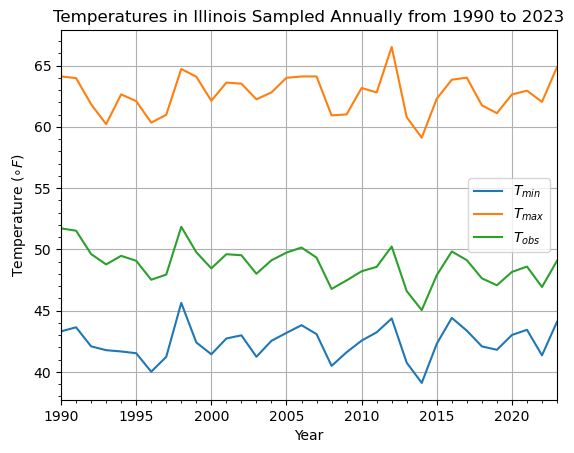

In [74]:
# Resamples the temperature data annually and calculate the mean
temp_data = desired_weather_pivot[["date", "TMIN", "TMAX", "TOBS"]]
temp_data.set_index("date", inplace = True)
resampled_temp_data = temp_data.resample("YE").mean()
resampled_temp_data.index = pd.to_datetime(resampled_temp_data.index)
tmin_label = r"$T_{min}$"
tmax_label = r"$T_{max}$"
tobs_label = r"$T_{obs}$"

# Plots TMIN, TMAX, and TOBS
plt.plot(resampled_temp_data.index.year, resampled_temp_data["TMIN"], label = tmin_label)
plt.plot(resampled_temp_data.index.year, resampled_temp_data["TMAX"], label = tmax_label)
plt.plot(resampled_temp_data.index.year, resampled_temp_data["TOBS"], label = tobs_label)

# Sets labels and title
plt.xlabel("Year")
plt.ylabel(r"Temperature ($\circ F$)")
plt.title("Temperatures in Illinois Sampled Annually from 1990 to 2023")

# Displays the legend
plt.legend(loc="best")

# Fixes the x-range so that it's between 1990 and 2023
plt.xlim(resampled_temp_data.index.year.min(), resampled_temp_data.index.year.max())

# Displays the grid
plt.grid()

# Displays minor ticks
plt.minorticks_on()

# Shows the plot
plt.show()

In [75]:
def moving_avg_plot(df, window_interval):
    """Creates a moving average plot specified at a certain interval.

    Args:
        df (pandas.DataFrame): dataframe used to preform the rolling average plot
        window_interval (int): the amount of years we want to do the rolling average over (i.e. 1 year, 3 years, etc.)
    """
    

    moving_average_temp_data = df.rolling(window = window_interval, min_periods = 1).mean()


    # Plots TMIN, TMAX, and TOBS with moving averages
    plt.plot(moving_average_temp_data.index.year, moving_average_temp_data["TMIN"], label = tmin_label)
    plt.plot(moving_average_temp_data.index.year, moving_average_temp_data["TMAX"], label = tmax_label)
    plt.plot(moving_average_temp_data.index.year, moving_average_temp_data["TOBS"], label = tobs_label)


    # Sets labels and title
    plt.xlabel("Year")
    plt.ylabel(r"Temperature ($\circ$F)")
    plt.title(f"{window_interval}-Year Moving Average of Temperatures in Illinois")

    # Displays the legend
    plt.legend(loc="best")

    # Adjusts the x-range to accommodate the moving average calculation
    plt.xlim(moving_average_temp_data.index.year.min(), moving_average_temp_data.index.year.max())

    # Displays the grid
    plt.grid()

    # Displays minor ticks
    plt.minorticks_on()

    # Shows the plot
    plt.show()

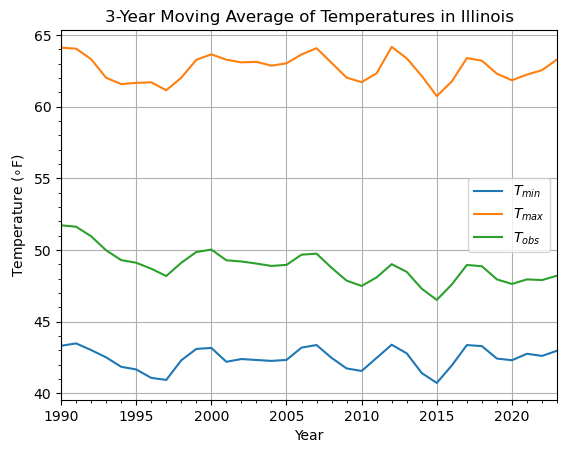

In [76]:
moving_avg_plot(resampled_temp_data, 3)

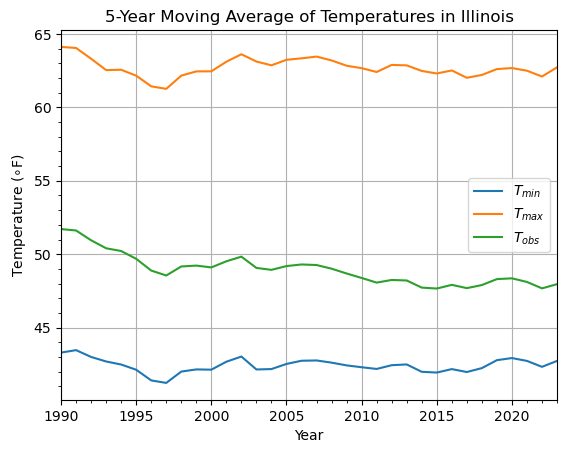

In [77]:
moving_avg_plot(resampled_temp_data, 5)

### The cell below plots the temeprature difference for the minimum, maximum, and observed temperatures.

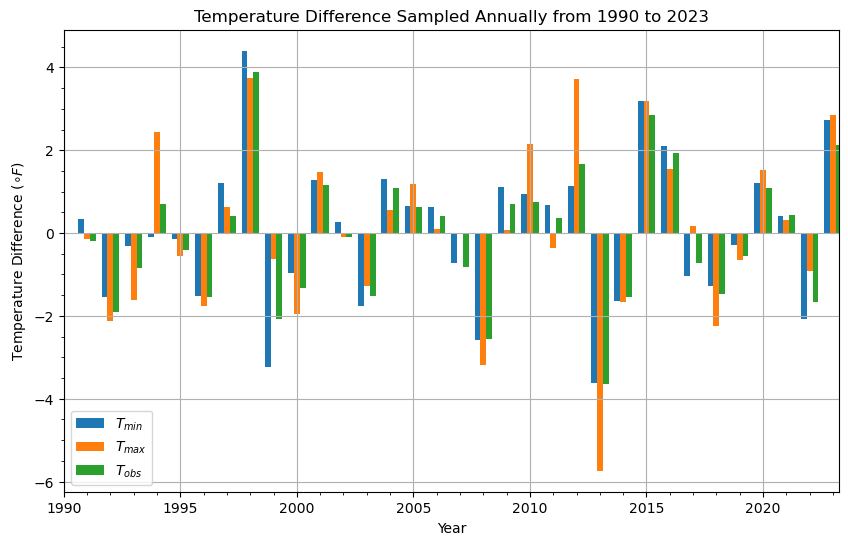

In [78]:
# Plots the temperature gradient (difference) for TMIN, TMAX, TOBS using grouped bars
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.25
years = resampled_temp_data.index.year
ax.bar(years - width, resampled_temp_data["TMIN"].diff(), width=width, label=tmin_label)
ax.bar(years, resampled_temp_data["TMAX"].diff(), width=width, label=tmax_label)
ax.bar(years + width, resampled_temp_data["TOBS"].diff(), width=width, label=tobs_label)
ax.set_xlabel("Year")
ax.set_ylabel(r"Temperature Difference ($\circ F$)")
ax.legend(loc="lower left")
ax.set_xlim(years.min(), years.max() + 0.25)
ax.set_title("Temperature Difference Sampled Annually from 1990 to 2023")
ax.grid()
ax.minorticks_on()
plt.show()

In [80]:
# Number of observations per station w.r.t. TMIN, TMAX, TOBS
num_obs_per_station = desired_weather_pivot.groupby("name", as_index = False).size().sort_values(by = "size", ascending = False)
num_obs_per_station

,name,size
848,HILLSBORO,32774
867,HOOPESTON,30256
1777,STOCKTON 3NNE,30170
347,CHARLESTON,30064
1306,NASHVILLE 1 E,28204
...,...,...
703,GALVA 0.4 NW,9
982,LEBANON 0.3 NE,5
613,ELLIS GROVE 1.5 SW,1
412,CLARENDON HILLS 0.6 S,1


                  name   size
848          HILLSBORO  32774
867          HOOPESTON  30256
1777     STOCKTON 3NNE  30170
347         CHARLESTON  30064
1306     NASHVILLE 1 E  28204
1644             SALEM  25123
889    JACKSONVILLE 2E  24672
604        ELGIN WATER  24587
1273        MT CARROLL  24582
894   JERSEYVILLE 2 SW  24482


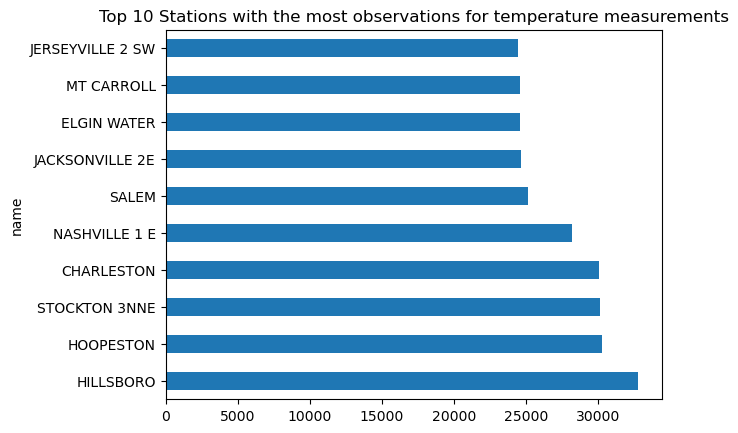

In [81]:
num_obs_per_station[:10].plot(x = "name", y = "size", kind = "barh", 
                              title = "Top 10 Stations with the most observations for temperature measurements", legend = False)
print(num_obs_per_station[:10])
plt.show()

In [82]:
num_obs_per_station.describe()

,size
count,2005.000000
mean,3774.827431
std,5997.091427
min,1.000000
25%,380.000000
50%,1190.000000
75%,3752.000000
max,32774.000000


In [83]:
quantiles_filter = ((num_obs_per_station["size"] > num_obs_per_station["size"].quantile(0.25)) & 
                   (num_obs_per_station["size"] < num_obs_per_station["size"].quantile(0.75)))
stations_in_between_quantiles = num_obs_per_station[quantiles_filter].sort_values(by = "size", ascending = False)
stations_in_between_quantiles

,name,size
62,ASHKUM 5.6 E,3729
615,ELMHURST 0.4 SW,3720
1793,STRONGHURST 0.4 SSW,3718
1619,ROGERS PARK 1.5 SW,3715
997,LILY LAKE 2.1 E,3714
...,...,...
117,BEARDSTOWN 0.6 WNW,384
481,DANVILLE 2.1 ESE,384
330,CHAMPAIGN 3.4 SSW,383
1576,REYNOLDS 0.4 NNE,383


                     name  size
62           ASHKUM 5.6 E  3729
615       ELMHURST 0.4 SW  3720
1793  STRONGHURST 0.4 SSW  3718
1619   ROGERS PARK 1.5 SW  3715
997       LILY LAKE 2.1 E  3714
1912      WATSEKA 6.9 WNW  3714
1200       MOLINE 0.7 NNE  3705
776   GRANITE CITY 2.3 NE  3675
114      BEACH PARK 1.4 W  3675
1399   ORANGEVILLE 2.8 NW  3671


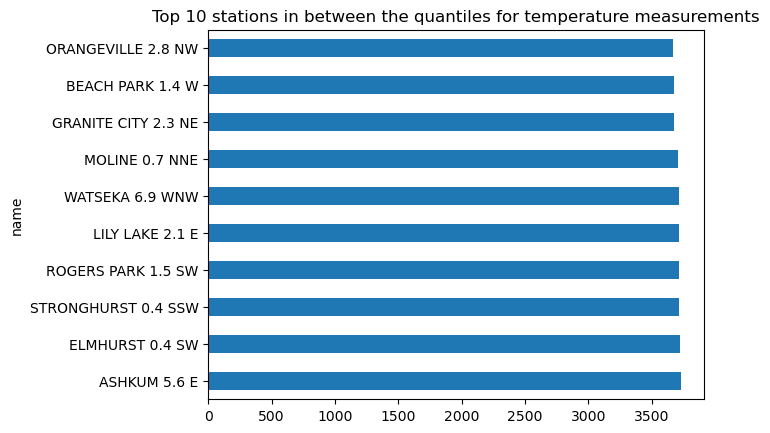

In [84]:
stations_in_between_quantiles[:10].plot(x = "name", y = "size", kind = "barh", 
                                        title = "Top 10 stations in between the quantiles for temperature measurements", legend = False)
print(stations_in_between_quantiles[:10])
plt.show()